In [12]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [103]:
def pad_embedding(embedding, max_length):
    return np.pad(embedding, (0, max_length - len(embedding)), mode='constant')

#dictionary in the form of category_id: color
categories = {
    -1: {"title": "Uncategorized", "color": "#808080"},
    7: {"title": "Data Science", "color": "#ff0000"},
    8: {"title": "Cryptocurrency", "color": "#ff8c00"},
    9: {"title": "Fintech", "color": "#e1ff00"},
    10: {"title": "Blockchain", "color": "#44ff00"},
    11: {"title": "Machine Learning", "color": "#00f7ff"},
    12: {"title": "Explainable AI", "color": "#0016de"},
    13: {"title": "Digital Economy", "color": "#a600ff"},
    14: {"title": "Maths & Stats", "color": "#59cdff"}
}

In [92]:
embeddings = pd.read_csv("../data/quantinar/quantinar_courselets.csv", sep=";")
embeddings["embedding"] = embeddings["embedding"].apply(str)
embeddings["embedding"] = embeddings["embedding"].apply(lambda x: np.array(x.split(","), dtype=np.float32))
max_length = max(embeddings["embedding"].apply(len))
embeddings["embedding"] = embeddings["embedding"].apply(lambda x: pad_embedding(x, max_length))
embeddings = embeddings.dropna()
embeddings.head()

,courselet_id,course_id,category_id,courselet_title,created_at,embedding
0,79,22,8,Introduction,2021-09-07 15:14:02,"[0.0063105742, 0.08922104, -0.0671587, 0.00420..."
1,81,207,13,DEDA Introduction,2021-09-13 12:44:07,"[0.007893738, 0.06831003, -0.07056951, 0.01098..."
2,82,210,13,DEDA Data Structures and Commonly Used Ops,2021-09-13 12:44:23,"[-0.0025516974, 0.06438406, -0.06445117, 0.007..."
3,83,213,13,DEDA Webscraping,2021-09-13 12:49:01,"[0.0030022352, 0.055884678, -0.064189315, 0.00..."
4,85,216,13,DEDA Webscraping Framework,2021-09-13 13:25:06,"[0.01188909, 0.06032688, -0.06895883, 0.024571..."


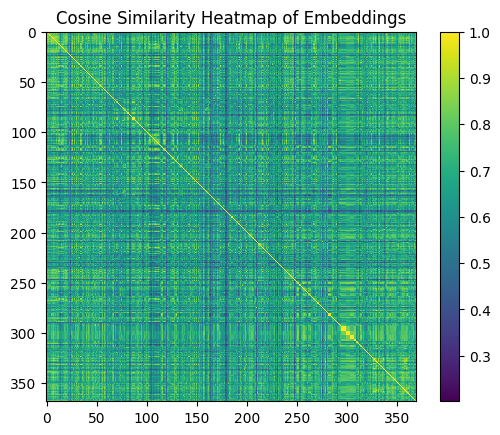

In [93]:
similarity_matrix = cosine_similarity(np.vstack(embeddings["embedding"].values))

# Plot the correlation matrix as a heatmap
plt.imshow(similarity_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Cosine Similarity Heatmap of Embeddings')
plt.show()

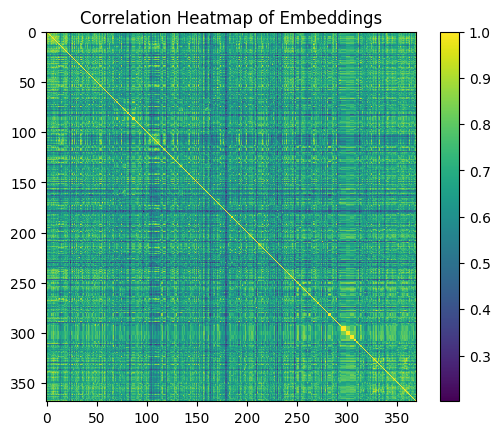

In [94]:
embeddings_val = np.vstack(embeddings["embedding"].values)

# Option A: Use np.corrcoef to compute pairwise correlation across all embeddings (row-wise)
correlation_matrix = np.corrcoef(embeddings_val)  # shape = (num_samples, num_samples)

# Option B: If you want correlation between embedding dimensions instead:
# correlation_matrix = np.corrcoef(embeddings.T)  # shape = (embedding_dim, embedding_dim)

# Plot the correlation matrix as a heatmap
plt.imshow(correlation_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap of Embeddings')
plt.savefig("correlation_heatmap.png", transparent=True, dpi=900)
plt.show()

In [95]:
threshold = 0.8
to_drop = set()

for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[0]):
        if correlation_matrix[i, j] > threshold:
            # Mark row j for removal (or row i, your choice)
            to_drop.add(j)

# Filter out the rows with high similarity
filtered_embeddings = np.delete(embeddings, list(to_drop), axis=0)
print(len(filtered_embeddings))

83


In [96]:
# Make a copy if you don't want to overwrite
corr_copy = correlation_matrix.copy()

# Replace the diagonal (self-correlation) with NaN
np.fill_diagonal(corr_copy, np.nan)

# Flatten the entire matrix (1D array) ignoring NaNs
flattened = corr_copy.flatten()
flattened = flattened[~np.isnan(flattened)]

mean_corr = np.mean(flattened)
median_corr = np.median(flattened)

print("Mean Correlation:", mean_corr)
print("Median Correlation:", median_corr)

Mean Correlation: 0.6639810642394885
Median Correlation: 0.6705847300938884


In [98]:
# Extract the group labels (e.g., from category_id)
group_labels = embeddings["category_id"].values
# Get a sorted index that clusters by group (ascending order)
sort_idx = np.argsort(group_labels)

# Apply this sorted index to BOTH rows and columns of your correlation matrix
reordered_corr = correlation_matrix[sort_idx, :][:, sort_idx]

# Also reorder the labels so we know which group is where
sorted_group_labels = group_labels[sort_idx]

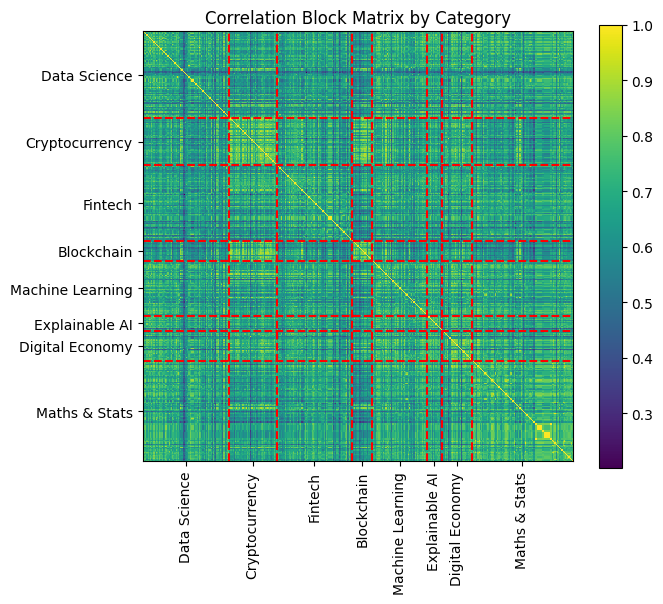

In [106]:
sort_idx = np.argsort(group_labels)
reordered_corr = correlation_matrix[sort_idx, :][:, sort_idx]
sorted_group_labels = group_labels[sort_idx]

# Identify boundaries
lines = []
current_label = sorted_group_labels[0]
for i in range(1, len(sorted_group_labels)):
    if sorted_group_labels[i] != current_label:
        lines.append(i)
        current_label = sorted_group_labels[i]

# We'll also append the final boundary (the end of the matrix)
lines.append(len(sorted_group_labels))

plt.figure(figsize=(7, 6))
plt.imshow(reordered_corr, interpolation='nearest')
plt.colorbar()
plt.title('Correlation Block Matrix by Category')

# We'll iterate through the boundary list, creating pairs (start, end)
start_idx = 0
all_block_centers = []
all_block_labels = []

for boundary_idx in lines:
    end_idx = boundary_idx
    # midpoint of this block:
    block_center = (start_idx + end_idx - 1) / 2.0  # -1 because of zero-based indexing
    # category_id is the label at the start index
    category_id_for_block = sorted_group_labels[start_idx]
    block_title = categories[category_id_for_block]["title"]

    # We'll store for labeling ticks
    all_block_centers.append(block_center)
    all_block_labels.append(str(block_title))

    start_idx = end_idx

# Draw boundary lines
for boundary in lines[:-1]:
    plt.axvline(x=boundary - 0.5, linestyle='--', color='red', linewidth=1.5)
    plt.axhline(y=boundary - 0.5, linestyle='--', color='red', linewidth=1.5)

# Set x- and y-ticks only at block centers
plt.xticks(ticks=all_block_centers, labels=all_block_labels, rotation=90)
plt.yticks(ticks=all_block_centers, labels=all_block_labels)

plt.tight_layout()
plt.savefig("correlation_category_block", transparent=True, dpi=900)
plt.show()
